<a href="https://colab.research.google.com/github/isaacdono/EA991-Atividade_03/blob/main/solucao/atividade_03_247175.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 03 - Regressão

Nesta atividade, vamos aplicar um conjunto de modelos de regressão ao problema de prever o número de passageiros.

Para isso, podemos utilizar o *dataset* disponível no Kaggle: https://www.kaggle.com/datasets/yasserh/air-passengers-forecast-dataset

![](https://raw.githubusercontent.com/Masterx-AI/Project_Forecasting_Air_Passengers__/main/ap.jpg)

Este *dataset* é formado por uma série temporal. O objetivo será o de utilizar o problema de regressão para realizar uma predição futura.

Se desejar usar um dataset ainda mais desafiador, alternativamente, é possível utilizar o *dataset* do Kaggle: https://www.kaggle.com/datasets/yyxian/u-s-airline-traffic-data

Esses dados usam valores de 2003 a 2023, sofrendo efeitos da pandemia, que podem ser mais difíceis de modelar. Nesse caso, é necessário fazer o download do *dataset* e ajustar o código a seguir, que carrega o primeiro *dataset*.


In [1]:
""" Importando os pacotes necessários """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preâmbulo: Carregando o *dataset* (arquivo .csv) para o Drive



In [2]:
""" Carregando o dataset do Github para trabalhar autonomamente no Colab """

import requests
from pathlib import Path

# Caminho para a pasta que conterá o dataset
data_path = Path("data/")

# Se o diretório ainda não existe, criamos e baixamos o dataset
if data_path.is_dir():
    print(f"O diretório {data_path} já existe")
else:
    print(f"Diretório {data_path} não localizado, criando um ...")
    data_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "airline-passengers.csv", "wb") as f:
        request = requests.get("https://github.com/EA991-Lab/utils/raw/main/data/airline-passengers.csv")
        print("Baixando os dados ...")
        f.write(request.content)

Diretório data não localizado, criando um ...
Baixando os dados ...


Com isso, o arquivo de dados estará disponível no Drive para uso através do caminho "data/airline-passengers.csv".


## Parte 1: Conhecendo o *dataset* e os detalhes do problema

a) Faça uma breve descrição do *dataset*, apontando quantidade de amostras. Faça um plot da série temporal para visualizá-la.

b) Como estamos lidando com uma série temporal e gostaríamos de realizar uma previsão de valores futuros, tanto as amostras de entrada X, quanto da saída Y fazem parte do "mesmo atributo". Nesse caso a divisão aleatória usual que separa treino e teste não pode ser aplicada. Devemos reservar apenas um trecho futuro para ser o teste, como ilustrado a seguir

![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*_wlOp86EnmpOd2k_kGbnNA.png)

Com base nisso, faça a divisão de amostras em conjunto de treino e de teste. Se desejar, veja o pacote https://www.sktime.net/en/v0.19.2/api_reference/auto_generated/sktime.forecasting.model_selection.temporal_train_test_split.html

c) Além disso, gostaríamos de utilizar um janelamento do dado de forma que, dado *n* valores passados, gostaríamos de prever o valor seguinte. Nesse sentido, as amostras devem ser organizadas conforme o exemplo a seguir:

![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*KsvjYITIbT1zxY6fdhi3Bg.png)

O janelamento pode ser feito utilizando bibliotecas (veja por exemplo https://www.sktime.net/en/v0.20.0/api_reference/auto_generated/sktime.forecasting.model_selection.SlidingWindowSplitter.html) ou implementado a partir dos comandos básicos em Python. Atente-se apenas ao fato de que o tamanho da janela será um hiperparâmetro.

Aplique o janelamento (janelas de tamanho *n*) no conjunto de treino e de teste.

d) Se necessário, crie um conjunto de validação e normalize os dados.

### Item a

<Axes: >

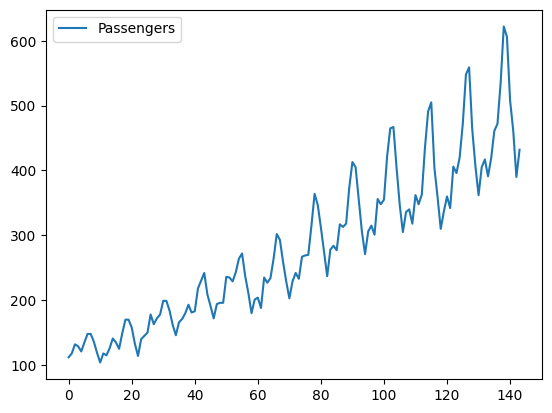

In [3]:
df = pd.read_csv('data/airline-passengers.csv')
df.plot()

**COMENTÁRIO:** Através de ``` df.head() ``` e  ``` df.tail() ``` verifica-se que o dataset contém 140 amostras mensais que vão de janeiro de 1949 a dezembro de 1960. Além disso, pelo gráfico, o dataset contém caráter periódico, sendo que o número de passageiros aumenta com o passar dos anos. Mais afundo, destacam-se 12 máximos locais (e 12 regiões parecidas entre si), o que pode indicar que o janelamento deva ser de 12 meses.



### Item b

In [4]:
!pip install sktime # Instala a lib sktime
from sktime.forecasting.model_selection import temporal_train_test_split

aux = df['Passengers']

train, test = temporal_train_test_split(aux) # É possível definir os ultimos n meses para teste

print("Treino:", train.shape)
print("Teste:", test.shape)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
    Uninstalling joblib-1.5.0:
      Successfully uninstalled joblib-1.5.0
Treino: (108,)
Teste: (36,)


### Item c

In [5]:
def create_windowed_data(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 24
X_train, y_train = create_windowed_data(train.values, window_size)
X_test, y_test = create_windowed_data(test.values, window_size)

In [25]:
len(X_train)

84

### Item d

In [6]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.preprocessing import StandardScaler

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criar validação
X_train_part, X_val = temporal_train_test_split(X_train_scaled, test_size=0.2)
y_train_part, y_val = temporal_train_test_split(y_train, test_size=0.2)


print(f"Dimensões das partições de dados\n")
print(f"Conjunto de treinamento: {X_train_part.shape}")
print(f"Conjunto de validação: {X_val.shape}")
print(f"Conjunto de teste: {X_test_scaled.shape}")


Dimensões das partições de dados

Conjunto de treinamento: (67, 24)
Conjunto de validação: (17, 24)
Conjunto de teste: (12, 24)


## Parte 2: Treinamento e avaliação da regressão linear

e) Aplique os modelos:
- Regressão Linear (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)  
- Ridge Regression variando alpha (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- Lasso Regression variando alpha (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
- ElasticNet variando alpha e l1_ratio (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
  
  

Selecione o modelo com os melhores hiperparâmetros e obtenha o desempenho no conjunto de teste em termos do MSE, RMSE e R². Comente qual foi o modelo com melhor desempenho.


### Item e

In [7]:
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
#lista de índices para a separação novamente em X_train_part e X_val dentro do GridSearch
split_index = [-1]*len(X_train_part) + [0]*len(X_val)

#cria o splitter de dados
pds = PredefinedSplit(test_fold = split_index)

#concatenar dados de treino e validacao
X_train_concat = np.concat([X_train_part, X_val], axis=0)
y_train_concat = np.concat([y_train_part, y_val], axis=0)

In [9]:
lr = LinearRegression()
lr.fit(X_train_concat, y_train_concat)
y_pred_lr = lr.predict(X_test_scaled)

In [10]:
ridge = Ridge()
params_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(ridge, params_ridge, cv=pds)
grid_ridge.fit(X_train_concat, y_train_concat)
y_pred_ridge = grid_ridge.predict(X_test_scaled)


In [11]:
lasso = Lasso(max_iter=10000)
params_lasso = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_lasso = GridSearchCV(lasso, params_lasso, cv=pds)
grid_lasso.fit(X_train_concat, y_train_concat)
y_pred_lasso = grid_lasso.predict(X_test_scaled)


In [12]:
elastic = ElasticNet(max_iter=10000)
params_elastic = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]
}
grid_elastic = GridSearchCV(elastic, params_elastic, cv=pds)
grid_elastic.fit(X_train_concat, y_train_concat)
y_pred_elastic = grid_elastic.predict(X_test_scaled)


In [13]:
# Funcao que calcula as metricas de avaliacao
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

# Armazenar resultados em um dicionario
results = {
    'Linear': evaluate(y_test, y_pred_lr),
    'Ridge': evaluate(y_test, y_pred_ridge),
    'Lasso': evaluate(y_test, y_pred_lasso),
    'ElasticNet': evaluate(y_test, y_pred_elastic),
}

# Acessar chave, valor para impressao
for name, (mse, rmse, r2) in results.items():
    print(f'{name}: MSE={mse:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}')


Linear: MSE=319.7981, RMSE=17.8829, R²=0.9423
Ridge: MSE=318.5905, RMSE=17.8491, R²=0.9425
Lasso: MSE=295.9636, RMSE=17.2036, R²=0.9466
ElasticNet: MSE=311.6698, RMSE=17.6542, R²=0.9437


**COMENTÁRIO:** O modelo Lasso teve o melhor desempenho, mas a diferença entre os modelos foi pequena. Isso sugere que os dados já se ajustam bem a um modelo linear, e a regularização não trouxe ganhos relevantes. Nota-se um desempenho semelhante ao dos modelos lineares com `window_size = 12`, cujo melhor resultado foi de  RMSE=15.2642, porém levemente inferior.

## Parte 3: Treinamento e avaliação do KNN

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

f) Mostre em um gráfico a variação da mesma métrica de desempenho no conjunto de validação em função do número de vizinhos ($k$). Comente.

g) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: MSE, RMSE e R².


### Item f

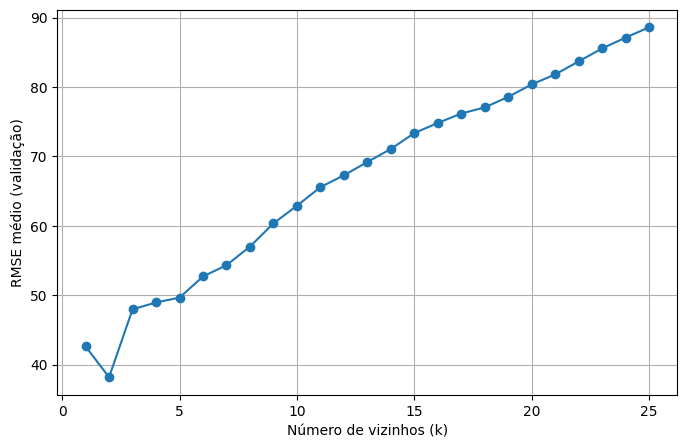

In [14]:
from sklearn.neighbors import KNeighborsRegressor

# GridSearch
knn = KNeighborsRegressor()
max_k = 25
params_knn = {
    'n_neighbors': np.arange(1, max_k+1),
}
grid_knn = GridSearchCV(knn, params_knn, cv=pds, scoring='neg_mean_squared_error')
grid_knn.fit(X_train_concat, y_train_concat)

# Plot
k_values = grid_knn.cv_results_['param_n_neighbors'].tolist()
rmse_scores = np.sqrt(-grid_knn.cv_results_['mean_test_score']) # NMSE multiplicado por -1
plt.figure(figsize=(8, 5))
plt.plot(k_values, rmse_scores, marker='o')
plt.xlabel('Número de vizinhos (k)')
plt.ylabel('RMSE médio (validação)')
plt.grid(True)
plt.show()

**COMENTÁRIO:** O gráfico mostra que o erro de predição (RMSE) atinge seu valor mínimo com k=2, sendo este um valor razoável e depois aumenta progressivamente com o número de vizinhos.

### Item g

In [15]:
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)

metrics = evaluate(y_test, y_pred_knn)
print(f'MSE: {metrics[0]:.4f}')
print(f'RMSE: {metrics[1]:.4f}')
print(f'R²: {metrics[2]:.4f}')

MSE: 12736.8542
RMSE: 112.8577
R²: -1.2993


**COMENTÁRIO:** Nota-se um desempenho insatisfatório do modelo KNN para este conjunto de dados, o elevado RMSE confirma o alto erro nas estimativas.

## Parte 4: Treinamento e avaliação da Árvore para Regressão

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

h) Mostre o desempenho no conjunto de validação variando o critério (*criterion*) e a profundidade máxima (*max_depth*). Comente.

i) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: MSE, RMSE e R².


### Item h

In [16]:
from sklearn.tree import DecisionTreeRegressor

# GridSearch
dt = DecisionTreeRegressor()
params_dt = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': np.arange(1, 21)
}
grid_dt = GridSearchCV(dt, params_dt, cv=pds, scoring='neg_mean_squared_error')
grid_dt.fit(X_train_concat, y_train_concat)

# Melhores parâmetros e desempenho
print("Melhores parâmetros:", grid_dt.best_params_)
print("Melhor score (neg_mean_squared_error):", grid_dt.best_score_)
print("RMSE correspondente:", np.sqrt(-grid_dt.best_score_))

Melhores parâmetros: {'criterion': 'squared_error', 'max_depth': np.int64(8)}
Melhor score (neg_mean_squared_error): -408.8235294117647
RMSE correspondente: 20.219384990937897


**COMENTÁRIO:** Com base nos resultados obtidos, a árvore de decisão com profundidade máxima 3 e critério friedman_mse apresentou desempenho razoável na parte de treinamento. O RMSE de aproximadamente 20,22 indica um bom erro médio.

### Item i

In [17]:
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test_scaled)

metrics = evaluate(y_test, y_pred_dt)
print(f'MSE: {metrics[0]:.4f}')
print(f'RMSE: {metrics[1]:.4f}')
print(f'R²: {metrics[2]:.4f}')

MSE: 5761.1667
RMSE: 75.9023
R²: -0.0400


**COMENTÁRIO:** A árvore de decisão teve desempenho ruim no conjunto de teste, o modelo não conseguiu generalizar.

## Parte 5: Treinamento e avaliação da SVR

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

j) Apresente uma curva de variação de uma métrica de desempenho nos dados de validação em função da largura da função *kernel* considerando a opção de *kernel* Gaussiano (ou `rbf`). Comente.

k) Descreva sucintamente a metodologia empregada e apresente os resultados obtidos no conjunto de teste pela melhor configuração do modelo, incluindo: MSE, RMSE e R².

### Item j

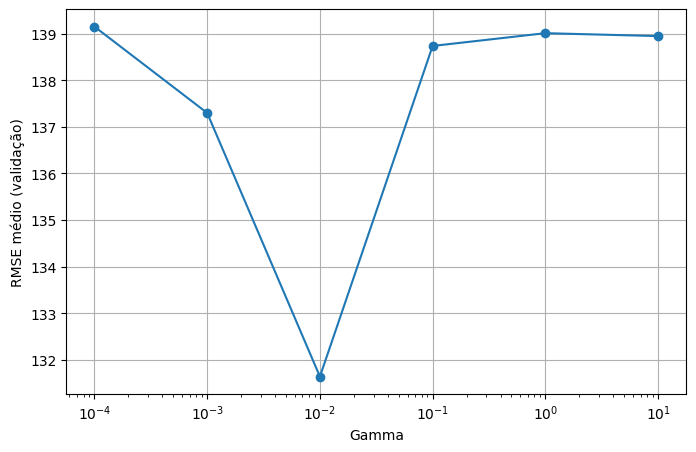

In [20]:
from sklearn.svm import SVR

# GridSearch
svr = SVR()
params_svr = {
    'kernel': ['rbf'],
    'gamma': np.logspace(-4, 1, 6)
}
grid_svr = GridSearchCV(svr, params_svr, cv=pds, scoring='neg_mean_squared_error')
grid_svr.fit(X_train_scaled, y_train)

# Plot
gamma_values = grid_svr.cv_results_['param_gamma'].tolist()
rmse_scores = np.sqrt(-grid_svr.cv_results_['mean_test_score']) # NMSE multiplicado por -1
plt.figure(figsize=(8, 5))
plt.plot(gamma_values, rmse_scores, marker='o')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('RMSE médio (validação)')
plt.grid(True)
plt.show()

**COMENTÁRIO:** O SVR apresentou desempenho fraco na validação, com RMSE médio de aproximadamente 132, indicando grande erro nas previsões. Isso sugere que o modelo teve dificuldade em capturar a estrutura da série temporal, possivelmente por sensibilidade a hiperparâmetros ou inadequação ao padrão dos dados com janelas curtas.


### Item k

In [19]:
best_svr = grid_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)

metrics = evaluate(y_test, y_pred_svr)
print(f'MSE: {metrics[0]:.4f}')
print(f'RMSE: {metrics[1]:.4f}')
print(f'R²: {metrics[2]:.4f}')

MSE: 54529.7586
RMSE: 233.5161
R²: -8.8439


**COMENTÁRIO:** O SVR teve desempenho muito ruim no teste, com R² negativo e RMSE elevado, indicando falha total em modelar a série temporal, resultado semelhante ao da primeira análise.

## Parte 6: Alteração no Tamanho da Janela

Use outro tamanho de janela e repita a análise dos modelos.

**Link para a primeira análise** (window_size = 12):

https://github.com/isaacdono/EA991-Atividade_03/blob/main/solucao/roteiro_atividade_03_v2_EA991_1s2025.ipynb